In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')
# from thunder.extraction.block.methods import grouplasso
from thunder.extraction.extraction import SourceExtraction
from thunder.extraction.block.mergers import OverlapBlockMerger
from scipy.io import loadmat
from scipy.misc import imsave
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from BlockGroupLasso import gaussian_group_lasso, GetCenters, GetROI

In [3]:
np.random.seed(1)
T = 30  # duration of the simulation
sz = (150, 100)  # size of image
sig = (5, 5)  # neurons size
foo = 0.1 * np.random.randn(*((T,) + sz))
bar = np.zeros((T,) + sz)
N = 15  # number of neurons
lam = 1
for i in range(N):
    ind = tuple([np.random.randint(x) for x in sz])
    for j in range(T):
        bar[(j,) + ind] = abs(np.random.randn())
data = foo + 10 * gaussian_filter(bar, (0,) + sig)
TargetArea = N * np.prod(2. * np.array(sig)) / np.prod(sz)
TargetRange = [TargetArea * 0.8, TargetArea * 1.2]
NonNegative = True
lam = 1

In [4]:
for i in range(len(data)):
    imsave("tmp/sim_%i.png"%i, data[i])

In [5]:
dataimg = tsc.loadImages('tmp', inputFormat='png').cache()

In [6]:
pic_data = np.percentile(data, 90, axis=0)
def plotModel(model):
    plt.figure(figsize=(20,6))
    plt.subplot(131)
    plt.scatter(*np.where(bar.max(0)>0));
    plt.imshow(pic_data.T);
    plt.title('Ground truth centers')
    plt.subplot(132)
    plt.scatter(*model.centers.T);
    plt.imshow(pic_data.T);
    plt.title('Inferred centers')
    plt.subplot(133)
    for i in range(len(model.coordinates)):
        plt.scatter(*(np.asarray(model.coordinates[i]).T), color=np.random.rand(3));
    plt.imshow(pic_data.T);
    plt.title('Inferred ROIs')

# just one block

In [7]:
data1 = dataimg.toBlocks()
data1.count()

1

## NMF from thunder

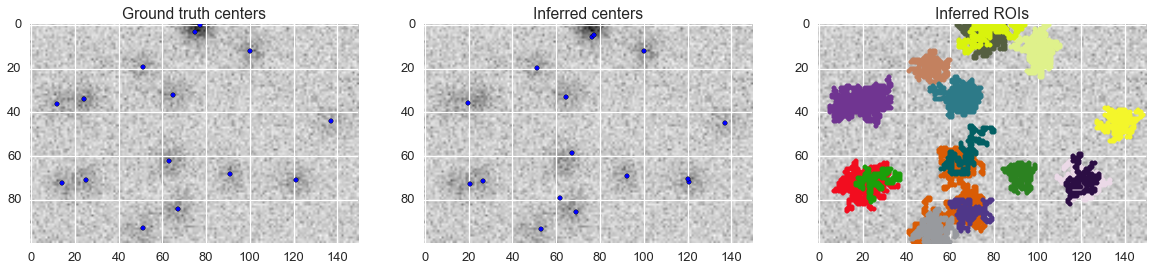

In [8]:
plotModel(SourceExtraction('nmf').fit(data1))

## GroupLasso - no spark

In [9]:
x = gaussian_group_lasso(data1.first()[1],
    sig, lam, NonNegative=NonNegative, TargetAreaRatio=TargetRange)
pic_x = np.percentile(x, 90, axis=0)
cent = GetCenters(pic_x)
ROI = GetROI(pic_x,  (np.array(cent)[:-1]).T)

Area Ratio = 0.87520,lambda=1.0000000
Area Ratio = 0.00000,lambda=10.0000000
Area Ratio = 0.03107,lambda=5.5000000
Area Ratio = 0.81447,lambda=3.2500000
Area Ratio = 0.72687,lambda=4.3750000
Area Ratio = 0.61753,lambda=4.9375000
Area Ratio = 0.15287,lambda=5.2187500
Area Ratio = 0.04613,lambda=5.3593750
Area Ratio = 0.10060,lambda=5.2890625


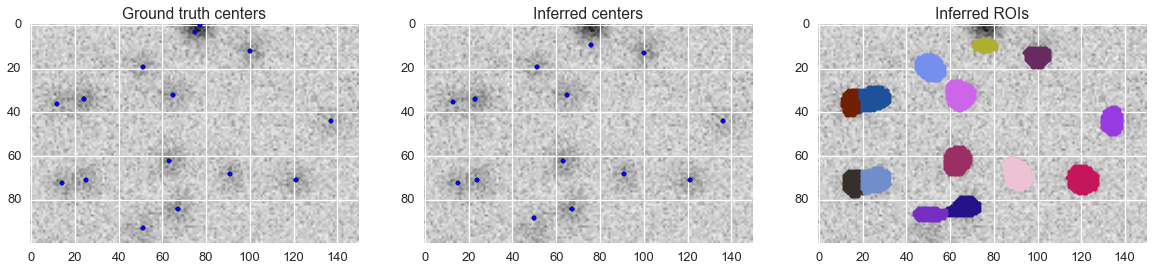

In [10]:
plt.figure(figsize=(20,6))
plt.subplot(131)
plt.scatter(*np.where(bar.max(0)>0));
plt.imshow(pic_data.T);
plt.title('Ground truth centers')
plt.subplot(132)
plt.scatter(*(np.array(cent)[:-1]));
plt.imshow(pic_data.T);
plt.title('Inferred centers')
plt.subplot(133)
for i in range(ROI.max()+1):
    plt.scatter(*np.where(ROI==i), color=np.random.rand(3));   
plt.imshow(pic_data.T);
plt.title('Inferred ROIs');

## GroupLasso for thunder

In [11]:
reload(thunder.extraction.block.methods.grouplasso)

<module 'thunder.extraction.block.methods.grouplasso' from '/Users/joe/thunder/python/thunder/extraction/block/methods/grouplasso.pyc'>

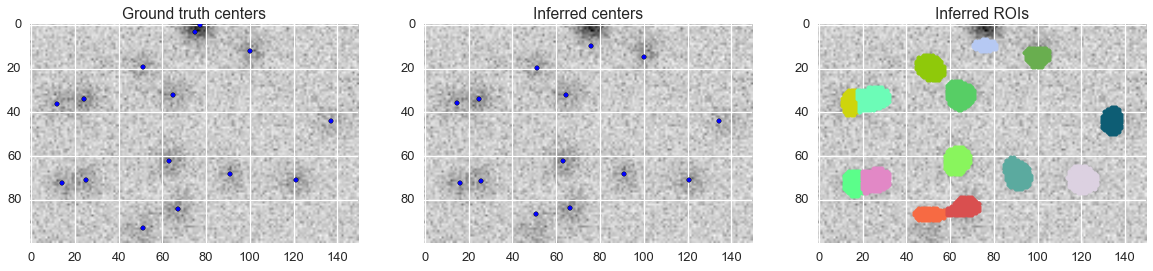

In [12]:
plotModel(SourceExtraction('grouplasso', sig=sig, nonNegative=True, verbose=True,
    targetAreaRatio=TargetRange, lam=lam).fit(data1))

# many blocks (here 6)

In [13]:
datapad = dataimg.toBlocks((50,50), padding=30)
datapad.count()

6

## NMF from thunder

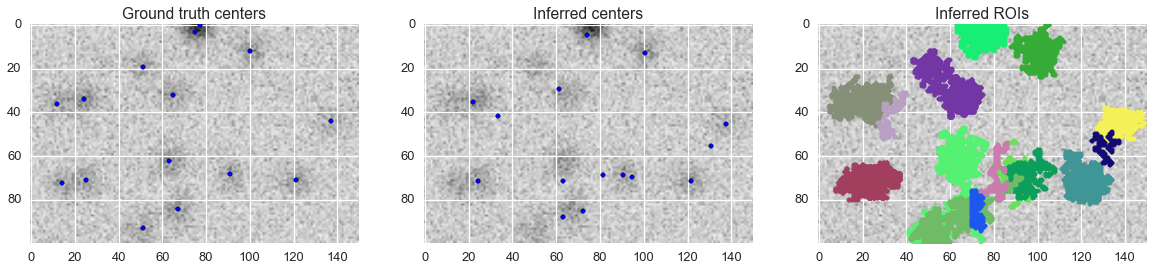

In [14]:
plotModel(SourceExtraction('nmf', merger=OverlapBlockMerger(.1)).fit(datapad))

## GroupLasso for thunder

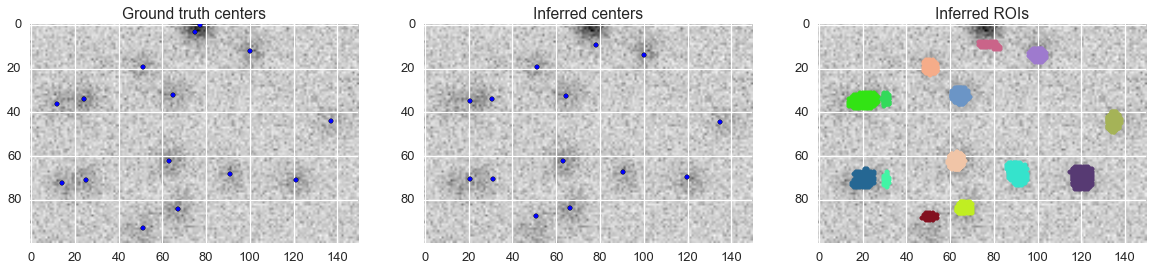

In [15]:
plotModel(SourceExtraction('grouplasso', merger=OverlapBlockMerger(.01), sig=sig, nonNegative=True, verbose=True,
    targetAreaRatio=map(lambda x:x/3, TargetRange), lam=lam).fit(datapad))